In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read in csv files as dataframes
songData = pd.read_csv('data_sample/end_song_sample.csv')
userData = pd.read_csv('data_sample/user_data_sample.csv')

In [4]:
#Merge dataframes with intersection on key of user_id
def mergedata(df1,df2):
    return pd.merge(df1, df2, how='inner', on=['user_id'])

In [5]:
#Drop rows with NaN values
userData2 = userData.dropna()
songData2 = songData.dropna()

Warm-up:
Determine whether male and female listeners are significantly different in their overall listening (in terms of the count of track listens, or in terms of the total time spent listening)

In [19]:
#Group by userID number of tracks and number of seconds played
seconds = songData2.groupby(["user_id"],as_index=False)['ms_played'].sum()
numofTracks = songData2.groupby(["user_id"],as_index=False)['track_id'].count()

In [20]:
#Put columns into UserData
df2 = mergedata(userData2,seconds)
df3 = mergedata(df2,numofTracks)

In [49]:
#Grab male and female listeners
maleUser = df3.loc[df3['gender'] == 'male']
femaleUser = df3.loc[df3['gender'] == 'female']

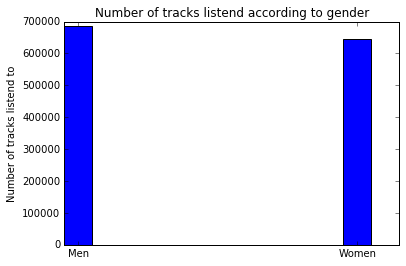

In [66]:
#Plot number of Track listens according to gender
numTrack = []
numTrack.append(sum(maleUser['track_id']))
numTrack.append(sum(femaleUser['track_id']))

fig, ax = plt.subplots()
ind = np.arange(len(numTrack))  
width = 0.1      
rects1 = ax.bar(ind, numTrack, width, color='b')

ax.set_ylabel('Number of tracks listend to')
ax.set_title('Number of tracks listend according to gender')

ax.set_xticks(ind+0.05)
ax.set_xticklabels(['Men','Women'])


plt.show()

As seen above the number of male users total in about 686179 track listens and females have about 686179 track listens. 

However this is probably due to the fact that there are more male listeners. If we find the average number of tracks for each male and female we see it is. 

In [76]:
#Average number of Tracks
mA = sum(maleUser['track_id'])/float(len(maleUser))
fA = sum(femaleUser['track_id'])/float(len(femaleUser))
print 'On average male users listen to ' + str(mA) +' tracks.'
print 'On average female users listen to ' + str(fA) + ' tracks.'

On average male users listen to 138.119766506 tracks.
On average female users listen to 141.891986828 tracks.


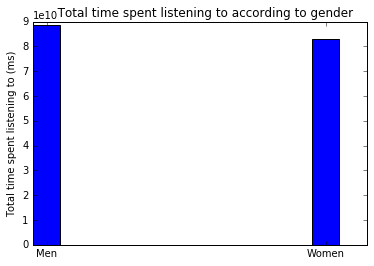

In [80]:
#Plot total time spent listening according to gender
timTrack = []
timTrack.append(sum(maleUser['ms_played']))
timTrack.append(sum(femaleUser['ms_played']))

fig, ax = plt.subplots()
ind = np.arange(len(timTrack))  
width = 0.1      
rects1 = ax.bar(ind, timTrack, width, color='b')

ax.set_ylabel('Total time spent listening to (ms)')
ax.set_title('   Total time spent listening to according to gender')

ax.set_xticks(ind+0.05)
ax.set_xticklabels(['Men','Women'])


plt.show()

As seen above the number of male users total in about 1477063.78 minutes played and females have about 1383889.51 mintues played. 
The average number of minutes played for each male and female we see is.

In [86]:
#Average number of Tracks
mA = sum(maleUser['ms_played'])/float(len(maleUser))
fA = sum(femaleUser['ms_played'])/float(len(femaleUser))
print 'On average male users listen to ' + str(mA/60000) +' minutess.'
print 'On average female users listen to ' + str(fA/60000) + ' minutes.'

On average male users listen to 297.31557548 ms.
On average female users listen to 303.817674643 ms.


Analysis suggestion 1:
Break the user listening into sessions (exactly what is a listening session is up to you to define) Look for correlations between user demographic features (or their behavior) and their overall listening, or their average session lengths
Analysis suggestion 2:
Find a clustering of user categories that delineates some interesting or useful behavior traits (or show that no clustering makes sense)

I will break users into a listening session on songData2. 
A listening session defines a continous stream of songs where the gap between the songs must be longer than 10 seconds and less than 2 minutes. 10 seconds because a user might click on a song just to see what the song is or accidently clicked the song. less than 2 mintues because the user might take a break. 
I will then find the average number of songs in a session for a user and also the average listening time in a session for a user, then compare user demographics based on a average number of songs in a session.

In [ ]:
#Converting Epoch time to global time
def time_convert(x):
    t1 = time.gmtime(x)
    t = time.mktime(t1)
    
    return t

In [ ]:
#Sort by User first then by timestamp
df_sort = songData2.sort(['user_id','end_timestamp'])
#List of unique user ids 
list_id = df_sort['user_id'].unique()

In [ ]:
#A session defined les than 2 minutes and longer than 10 seconds
def getsessions(test,test2):
    ulimit = 2*60
    blimit = 10
    seshid = 1
    sesh = []
    for i in range(len(test2)):
        c = test2[i] - test.loc[i]['ms_played']/1000
        if np.isnan(c):
            sesh.append(1)
        elif c < ulimit and c >= blimit:
            sesh.append(seshid)
        elif c >= ulimit or c < blimit:
            seshid += 1
            sesh.append(seshid)
    return sesh

In [ ]:
#Get average number of songs in session and average session length
avg_num_songs = []
avg_song_sec = []
for j in range(len(list_id)):
    test = df_sort.loc[df_sort['user_id'] == list_id[j]]
    test['timestamp_sec'] = test['end_timestamp'].apply(lambda x : time_convert(x))
    test = test.reset_index()
    test2 = test.groupby(['user_id'])['timestamp_sec'].diff()
    sesh = getsessions(test,test2)
    se = pd.Series(sesh)
    test['sesh_id'] = se.values
    avg_num_songs.append(test.groupby(['sesh_id'])['sesh_id'].count().sum()/float(len(set(sesh))))
    avg_song_sec.append(test.groupby(['sesh_id'])['ms_played'].sum().sum()/float(len(set(sesh))))

In [ ]:
#Create new dataframe for average session data write to csv
ns = pd.Series(avg_num_songs,name='avg_num_songs')
ss = pd.Series(avg_song_sec,name='avg_song_sec')
lid = pd.Series(list_id,name='user_id')
df_avg = pd.concat([lid,ns, ss], axis=1)
#df_avg.to_csv('avg_num.csv')

In [6]:
#Read in csv for average session
avg_num = pd.read_csv('avg_num.csv')
#Merge with User data
avgSessiondata = mergedata(avg_num,userData2)

In [7]:
avgSessiondata.head()

,Unnamed: 0,user_id,avg_num_songs,avg_song_sec,gender,age_range,country,acct_age_weeks
0,0,000eb8799c9344c8853e8a2b57d835ff,1.254545,317626.654545,male,25 - 29,GB,39
1,1,001b9229782940c39f311c3d5fa3bdc9,1.071429,12590.785714,female,18 - 24,FR,13
2,2,001cc057631d49ba81e30919dc12920f,1.000000,101387.625000,female,18 - 24,US,149
3,3,001eacb8a417475ca5c66600c6333ebc,1.071429,78585.250000,female,30 - 34,MX,30
4,4,001fbc268150424e82b2af6a13b300eb,1.185567,243781.443299,male,18 - 24,GB,342


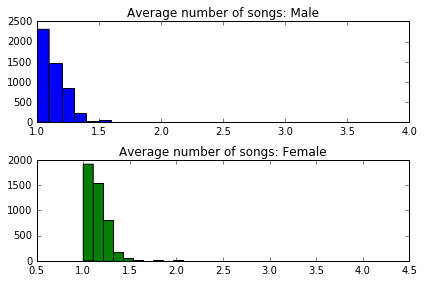

In [13]:
#Compare average number of songs in session based on Gender
avgMale = avgSessiondata.loc[avgSessiondata['gender'] == 'male']['avg_num_songs']
avgFemale = avgSessiondata.loc[avgSessiondata['gender'] == 'female']['avg_num_songs']
plt.subplot(2, 1, 1)
plt.hist(avgMale,bins=30,color='b')
plt.title('Average number of songs: Male')

plt.subplot(2, 1, 2)
plt.hist(avgFemale,bins=30,color='g')
plt.title('Average number of songs: Female')

plt.tight_layout()
plt.show()

Based on the histograms above the average number of songs in a listening session for Females and Males are similar.

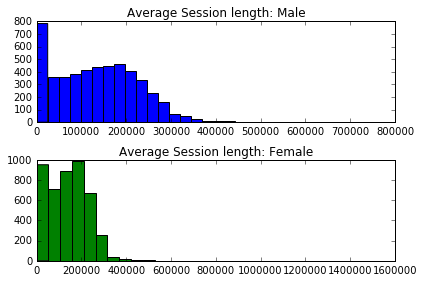

In [14]:
#Compare average session length based on Gender
avgMale = avgSessiondata.loc[avgSessiondata['gender'] == 'male']['avg_song_sec']
avgFemale = avgSessiondata.loc[avgSessiondata['gender'] == 'female']['avg_song_sec']
plt.subplot(2, 1, 1)
plt.hist(avgMale,bins=30,color='b')
plt.title('Average Session length: Male')

plt.subplot(2, 1, 2)
plt.hist(avgFemale,bins=30,color='g')
plt.title('Average Session length: Female')

plt.tight_layout()
plt.show()

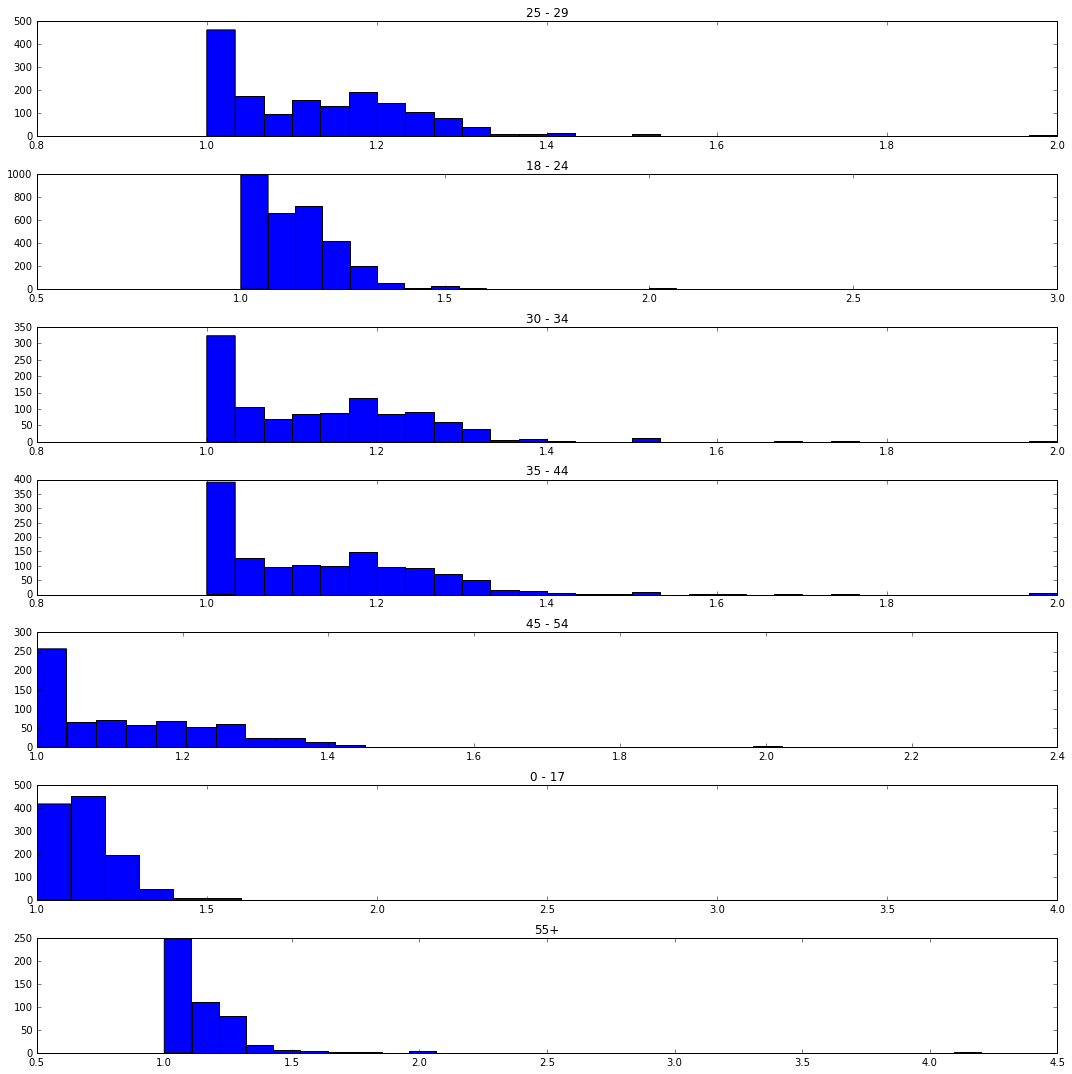

In [16]:
#Compare average number of songs in session based on age Range
plt.figure(figsize=(15,15))
ageRange = avgSessiondata['age_range'].unique()
for i in range(len(ageRange)):
    plt.hold()
    plt.subplot(len(ageRange), 1, i+1)
    avgAge = avgSessiondata.loc[avgSessiondata['age_range'] == ageRange[i]]['avg_num_songs']
    plt.hist(avgAge,bins=30,color='b')
    plt.title(str(ageRange[i]))
    plt.tight_layout()


Based on the histograms above age range does not show any dramatic differences in average listening sessions.

I will now look into user behavior and its regard to average listening sessions. I will look into context or how does the user listen to songs whether it be playlist,album,artist etc.

In [92]:
context = songData2.groupby(["context"],as_index = False)['track_id'].count()

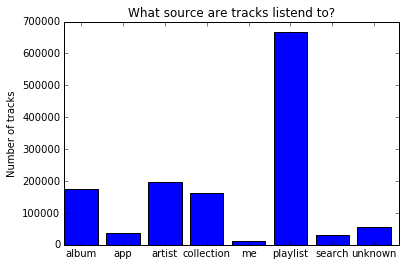

In [94]:
#The number of songs found through each context
fig, ax = plt.subplots()
ind = np.arange(len(context))  
width = 0.4    
rects1 = ax.bar(ind, context['track_id'], color='b')

ax.set_ylabel('Number of tracks')
ax.set_title('What source are tracks listend to?')

ax.set_xticks(ind + width)
ax.set_xticklabels(context['context'])

plt.show()

Above we see that most songs are listened through the playlist feature.

To see how context affects each user I see for each user how many songs are played through each context.

In [17]:
#Function to help turn a concated list into dictionary
from collections import Counter

def convert(L):
    K = Counter(L).keys()
    V = Counter(L).values()
    D = {k:v for k,v in zip(K,V)}
    
    return D

In [21]:
#Create dataframe that has each context as column and number of times used for user
test = songData2.groupby(["user_id"],as_index = False)['context'].agg({'context':lambda g: [i for i in g]})
test['context'] = test['context'].apply(convert)
df_context = pd.DataFrame.from_records(test['context']).fillna(value=0)
df4 = pd.concat([test, df_context], axis=1)
df4.drop('context', axis=1, inplace=True)
df5 = mergedata(df3,df4)

In [23]:
#Find the most used context for each user
df5['maxcontext'] = df5.iloc[:,7:].idxmax(axis=1)
dfcontext = mergedata(df5,avg_num)

In [24]:
dfcontext.head()

,gender,age_range,country,acct_age_weeks,user_id,ms_played,track_id,album,app,artist,collection,me,playlist,search,unknown,maxcontext,Unnamed: 0,avg_num_songs,avg_song_sec
0,male,25 - 29,FR,329,97f47c9fba714ca68320b8a80e010a1a,29398352,96,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,playlist,5652,1.411765,432328.705882
1,female,45 - 54,US,178,d615ca85849d458e9a5d755ec4727e8f,31999,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,artist,7980,1.000000,31999.000000
2,female,18 - 24,DE,68,6c83a5bf63b74f85b106ac7e7e015a1b,29986258,178,15.0,0.0,50.0,24.0,0.0,89.0,0.0,0.0,playlist,4086,1.328358,223778.044776
3,female,30 - 34,US,8,530fcedb3f244e6f91ecb326740005eb,24333,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,artist,3158,1.000000,12166.500000
4,female,30 - 34,FR,42,d2ed6a815eda4f61aa346b7936d03ef7,5395128,39,19.0,0.0,2.0,0.0,0.0,17.0,1.0,0.0,album,7849,1.054054,145814.270270


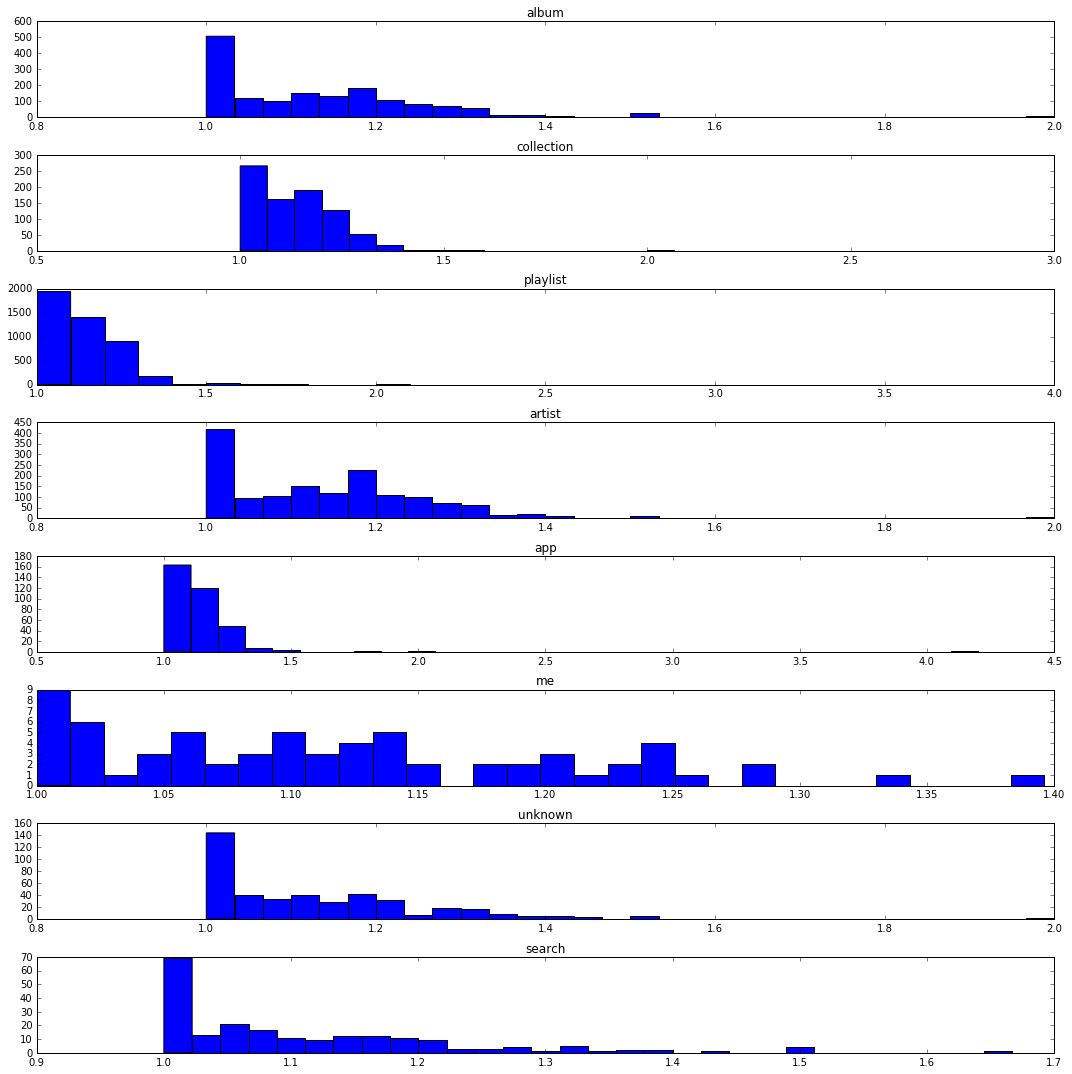

In [25]:
#Compare average number of songs in session based on context
plt.figure(figsize=(15,15))
context = songData2['context'].unique()
for i in range(len(context)):
    plt.hold()
    plt.subplot(len(context), 1, i+1)
    avgC = dfcontext.loc[dfcontext['maxcontext'] == context[i]]['avg_num_songs']    
    plt.hist(avgC,bins=30,color='b')
    plt.title(str(context[i]))
    plt.tight_layout()

Based on the histograms albums and artists have similar distributions for average number of songs in a session.
Playlist and collection also have similar distribution. 

This is probably due to the fact that when on an album page a listener is more willing to listen to the whole album making the number of songs in a listening session longer.

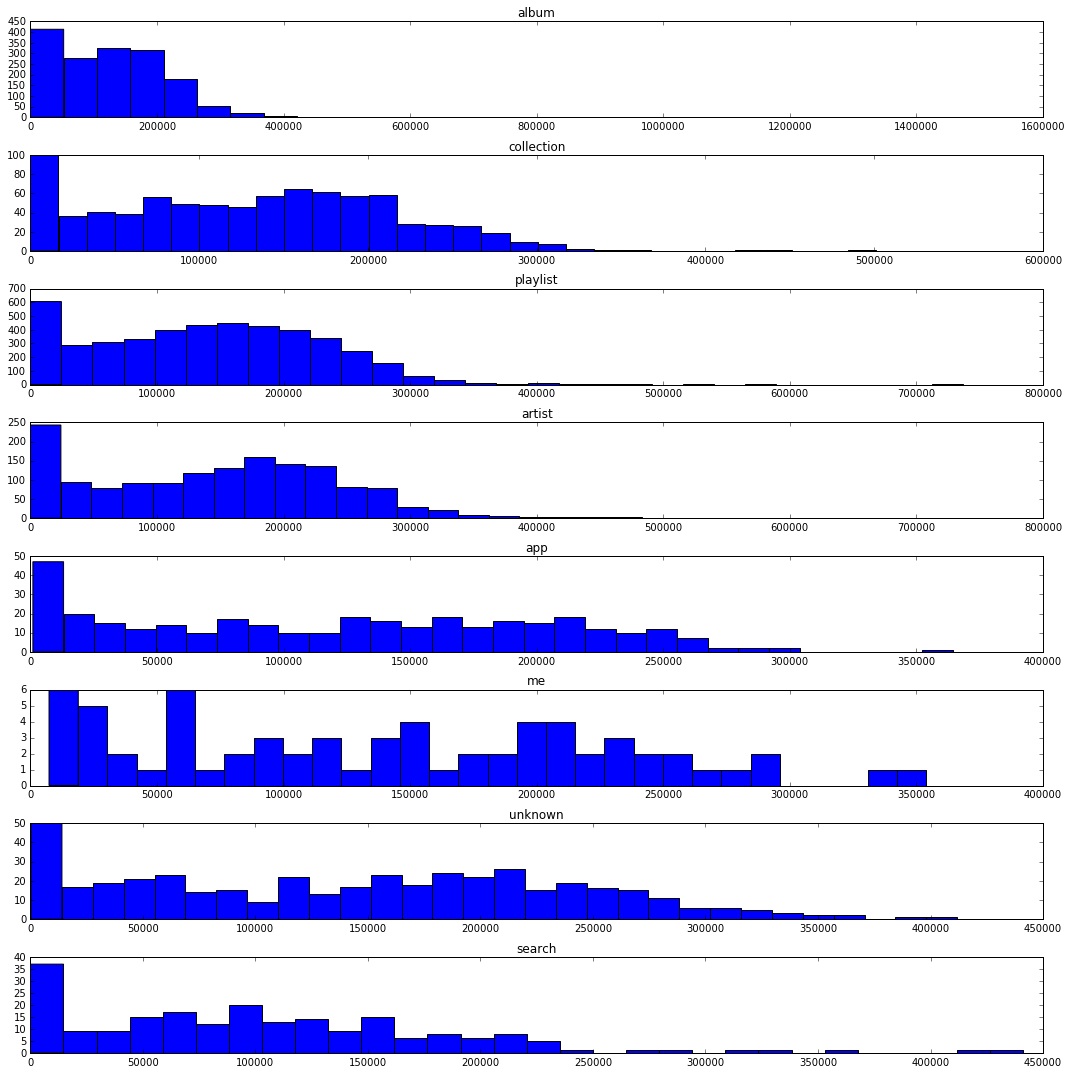

In [26]:
#Compare average session length based on context
plt.figure(figsize=(15,15))
context = songData2['context'].unique()
for i in range(len(context)):
    plt.hold()
    plt.subplot(len(context), 1, i+1)
    avgC = dfcontext.loc[dfcontext['maxcontext'] == context[i]]['avg_song_sec']    
    plt.hist(avgC,bins=30,color='b')
    plt.title(str(context[i]))
    plt.tight_layout()

Distributions for average session length for context look similar. 

Another user behavior is through what product is the User listening too. 

In [96]:
product = songData2.groupby(["product"],as_index = False)['track_id'].count()

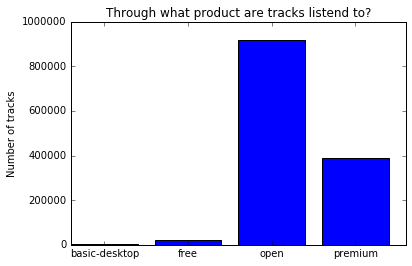

In [101]:
#The number of songs found through each product
fig, ax = plt.subplots()
ind = np.arange(len(product))  
width = 0.4    
rects1 = ax.bar(ind, product['track_id'], color='b')

ax.set_ylabel('Number of tracks')
ax.set_title('Through what product are tracks listend to?')

ax.set_xticks(ind + width)
ax.set_xticklabels(product['product'])

plt.show()

As seen above open has the most number of tracks played through it. 

If you sign-up directly from the Spotify website, the only free option available is Spotify Open. But if you know someone with an invite, you can use it to sign up for Spotify Free giving you unlimited listening for the first six months.

In [27]:
#Create dataframe that has each product as column and number of times used for user
test = songData2.groupby(["user_id"],as_index = False)['product'].agg({'product':lambda g: [i for i in g]})
test['product'] = test['product'].apply(convert)
df_product = pd.DataFrame.from_records(test['product']).fillna(value=0)
df4 = pd.concat([test, df_product], axis=1)
df4.drop('product', axis=1, inplace=True)
df6 = mergedata(df3,df4)

In [37]:
#Find the most used product for each user
df6['maxproduct'] = df6.iloc[:,7:].idxmax(axis=1)
dfproduct = mergedata(df6,avg_num)

In [39]:
dfproduct.head()

,gender,age_range,country,acct_age_weeks,user_id,ms_played,track_id,basic-desktop,free,open,premium,maxproduct,Unnamed: 0,avg_num_songs,avg_song_sec
0,male,25 - 29,FR,329,97f47c9fba714ca68320b8a80e010a1a,29398352,96,0.0,96.0,0.0,0.0,free,5652,1.411765,432328.705882
1,female,45 - 54,US,178,d615ca85849d458e9a5d755ec4727e8f,31999,1,0.0,0.0,1.0,0.0,open,7980,1.000000,31999.000000
2,female,18 - 24,DE,68,6c83a5bf63b74f85b106ac7e7e015a1b,29986258,178,0.0,0.0,178.0,0.0,open,4086,1.328358,223778.044776
3,female,30 - 34,US,8,530fcedb3f244e6f91ecb326740005eb,24333,2,0.0,0.0,2.0,0.0,open,3158,1.000000,12166.500000
4,female,30 - 34,FR,42,d2ed6a815eda4f61aa346b7936d03ef7,5395128,39,0.0,0.0,0.0,39.0,premium,7849,1.054054,145814.270270


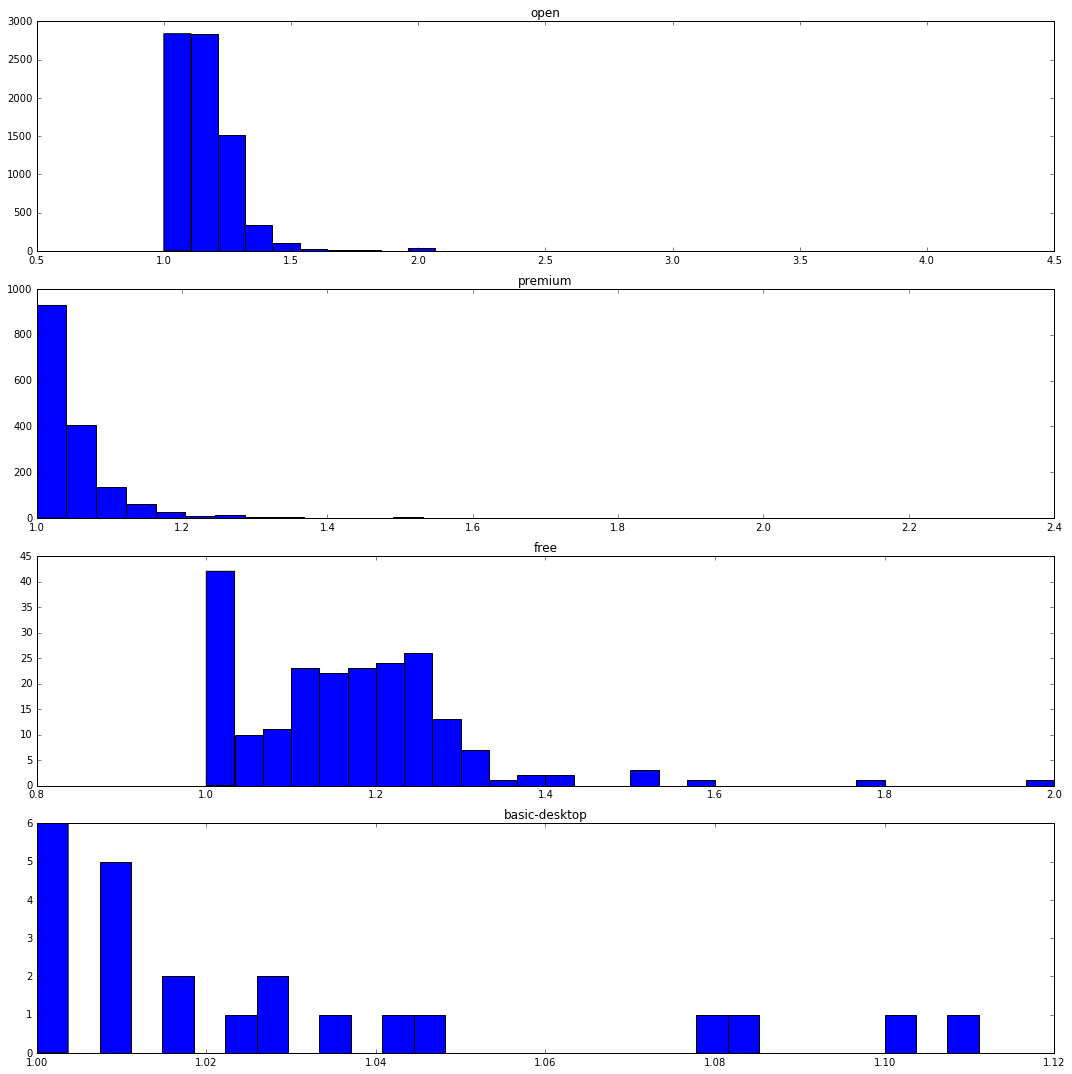

In [40]:
#Compare average number of songs in session based on product
plt.figure(figsize=(15,15))
product = songData2['product'].unique()
for i in range(len(product)):
    plt.hold()
    plt.subplot(len(product), 1, i+1)
    avgC = dfproduct.loc[dfproduct['maxproduct'] == product[i]]['avg_num_songs']    
    plt.hist(avgC,bins=30,color='b')
    plt.title(str(product[i]))
    plt.tight_layout()

Based on the histogram above we see that the Spotify free distribution has a higher number of users with longer average session time. Possibly due to the fact that Spotify free gives users a free 6 months so users want to take advantage of this fact and listen to more songs.

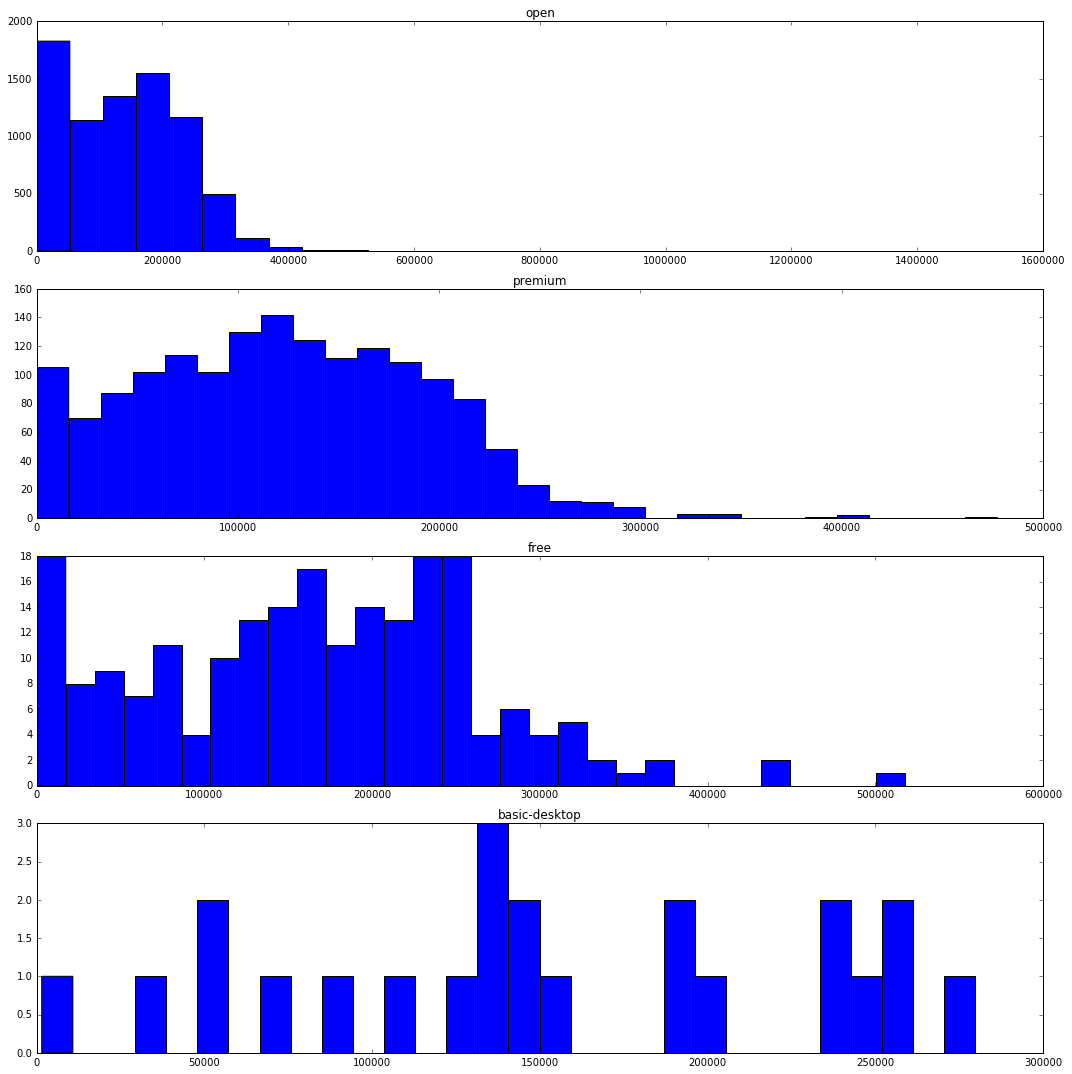

In [41]:
#Compare average session length based on product
plt.figure(figsize=(15,15))
product = songData2['product'].unique()
for i in range(len(product)):
    plt.hold()
    plt.subplot(len(product), 1, i+1)
    avgC = dfproduct.loc[dfproduct['maxproduct'] == product[i]]['avg_song_sec']    
    plt.hist(avgC,bins=30,color='b')
    plt.title(str(product[i]))
    plt.tight_layout()

Conclusion: With average number of songs in a session there is not a discriminating factor when it comes to user demographics. However when it comes to user behavior, sessions seem to have more songs on album and artist pages and with accounts of Spotify free(first 6 months free).